In [2]:
import numpy as np 
import pandas as pd 

from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

# Análisis exploratorio de datos

In [3]:
data = pd.read_csv('Sentiment.csv')
data.head(20)

,id,candidate,candidate_confidence,relevant_yn,relevant_yn_confidence,sentiment,sentiment_confidence,subject_matter,subject_matter_confidence,candidate_gold,name,relevant_yn_gold,retweet_count,sentiment_gold,subject_matter_gold,text,tweet_coord,tweet_created,tweet_id,tweet_location,user_timezone
0,1,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6578,None of the above,1.0000,NaN,I_Am_Kenzi,NaN,5,NaN,NaN,RT @NancyLeeGrahn: How did everyone feel about...,NaN,2015-08-07 09:54:46 -0700,629697200650592256,NaN,Quito
1,2,Scott Walker,1.0000,yes,1.0000,Positive,0.6333,None of the above,1.0000,NaN,PeacefulQuest,NaN,26,NaN,NaN,RT @ScottWalker: Didn't catch the full #GOPdeb...,NaN,2015-08-07 09:54:46 -0700,629697199560069120,NaN,NaN
2,3,No candidate mentioned,1.0000,yes,1.0000,Neutral,0.6629,None of the above,0.6629,NaN,PussssyCroook,NaN,27,NaN,NaN,RT @TJMShow: No mention of Tamir Rice and the ...,NaN,2015-08-07 09:54:46 -0700,629697199312482304,NaN,NaN
3,4,No candidate mentioned,1.0000,yes,1.0000,Positive,1.0000,None of the above,0.7039,NaN,MattFromTexas31,NaN,138,NaN,NaN,RT @RobGeorge: That Carly Fiorina is trending ...,NaN,2015-08-07 09:54:45 -0700,629697197118861312,Texas,Central Time (US & Canada)
4,5,Donald Trump,1.0000,yes,1.0000,Positive,0.7045,None of the above,1.0000,NaN,sharonDay5,NaN,156,NaN,NaN,RT @DanScavino: #GOPDebate w/ @realDonaldTrump...,NaN,2015-08-07 09:54:45 -0700,629697196967903232,NaN,Arizona
5,6,Ted Cruz,0.6332,yes,1.0000,Positive,0.6332,None of the above,1.0000,NaN,DRJohnson11,NaN,228,NaN,NaN,"RT @GregAbbott_TX: @TedCruz: ""On my first day ...",NaN,2015-08-07 09:54:44 -0700,629697194283499520,NaN,Central Time (US & Canada)
6,7,No candidate mentioned,1.0000,yes,1.0000,Negative,0.6761,FOX News or Moderators,1.0000,NaN,DebWilliams57,NaN,17,NaN,NaN,RT @warriorwoman91: I liked her and was happy ...,NaN,2015-08-07 09:54:44 -0700,629697192383672320,North Georgia,Eastern Time (US & Canada)
7,8,No candidate mentioned,1.0000,yes,1.0000,Neutral,1.0000,None of the above,1.0000,NaN,RaulAReyes,NaN,0,NaN,NaN,Going on #MSNBC Live with @ThomasARoberts arou...,NaN,2015-08-07 09:54:44 -0700,629697192169750528,New York NY,Eastern Time (US & Canada)
8,9,Ben Carson,1.0000,yes,1.0000,Negative,0.6889,None of the above,0.6444,NaN,kengpdx,NaN,0,NaN,NaN,Deer in the headlights RT @lizzwinstead: Ben C...,NaN,2015-08-07 09:54:44 -0700,629697190219243524,NaN,Pacific Time (US & Canada)
9,10,No candidate mentioned,0.4594,yes,0.6778,Negative,0.6778,None of the above,0.4594,NaN,Kathielarsyn,NaN,1,NaN,NaN,RT @NancyOsborne180: Last night's debate prove...,NaN,2015-08-07 09:54:42 -0700,629697185093824512,NaN,NaN


In [4]:
data.dtypes

id                             int64
candidate                     object
candidate_confidence         float64
relevant_yn                   object
relevant_yn_confidence       float64
sentiment                     object
sentiment_confidence         float64
subject_matter                object
subject_matter_confidence    float64
candidate_gold                object
name                          object
relevant_yn_gold              object
retweet_count                  int64
sentiment_gold                object
subject_matter_gold           object
text                          object
tweet_coord                   object
tweet_created                 object
tweet_id                       int64
tweet_location                object
user_timezone                 object
dtype: object

In [5]:
data.describe()

,id,candidate_confidence,relevant_yn_confidence,sentiment_confidence,subject_matter_confidence,retweet_count,tweet_id
count,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,13871.000000,1.387100e+04
mean,6936.000000,0.855689,0.927304,0.756936,0.782801,45.803331,6.296058e+17
std,4004.357127,0.241388,0.141696,0.217682,0.258215,153.981724,9.611863e+13
min,1.000000,0.222200,0.333300,0.186000,0.222200,0.000000,6.294531e+17
25%,3468.500000,0.674200,1.000000,0.651700,0.641300,0.000000,6.294861e+17
50%,6936.000000,1.000000,1.000000,0.681300,1.000000,2.000000,6.296726e+17
75%,10403.500000,1.000000,1.000000,1.000000,1.000000,44.000000,6.296882e+17
max,13871.000000,1.000000,1.000000,1.000000,1.000000,4965.000000,6.297017e+17


In [6]:
# Keeping only the neccessary columns
data = data[['text','sentiment']]

# Limpiamos el texto y tokenizamos

In [7]:
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Neutral'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

4472
6284
16986


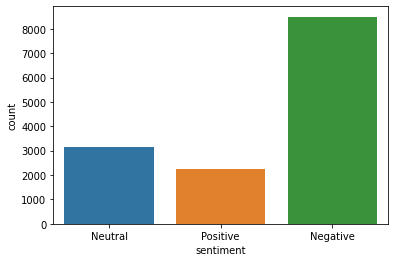

In [8]:
import seaborn as sns
sns.countplot(x=data['sentiment'], data=data)

In [9]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 28, 128)           256000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 28, 128)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 196)               254800    
_________________________________________________________________
dense (Dense)                (None, 3)                 591       
Total params: 511,391
Trainable params: 511,391
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(9293, 28) (9293, 3)
(4578, 28) (4578, 3)


In [11]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
291/291 - 33s - loss: 0.8376 - accuracy: 0.6422
Epoch 2/7
291/291 - 33s - loss: 0.7015 - accuracy: 0.6975
Epoch 3/7
291/291 - 33s - loss: 0.6422 - accuracy: 0.7279
Epoch 4/7
291/291 - 33s - loss: 0.6014 - accuracy: 0.7508
Epoch 5/7
291/291 - 33s - loss: 0.5648 - accuracy: 0.7664
Epoch 6/7
291/291 - 33s - loss: 0.5352 - accuracy: 0.7753
Epoch 7/7
291/291 - 33s - loss: 0.5021 - accuracy: 0.7952


In [12]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

97/97 - 1s - loss: 0.8236 - accuracy: 0.6556
score: 0.82
acc: 0.66


(WIP)

In [ ]:
pos_cnt, neg_cnt, neu_cnt, pos_correct, neg_correct, neu_correct = 0, 0, 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]


    print(result)
    if np.argmax(result) == np.argmax(Y_validate[0]):
            neg_correct += 1
    elif np.argmax(result) == np.argmax(Y_validate[1]) :
            neu_correct += 1
    else:
         pos_correct += 1
       
    if np.argmax(Y_validate[0]) == 1:
        neg_cnt += 1
    elif np.argmax(Y_validate[1]) == 1:
        neu_cnt +=1
    else:
        pos_cnt += 1

print("ya")
print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neu_acc", neu_correct/neu_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")